# Creating Table of features from datas

In [2]:
import uproot as up
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

plt.style.use('seaborn-v0_8-paper')
plt.rcParams["patch.force_edgecolor"] = True

## Imprting datasets
For the dataset we will use
- ibd_userfile_new_production
- radioactivity_userfile_7days

for the background.

In [3]:
file_BKG = up.open("../../../../mnt/fcufino/radioactivity_userfile_1days.root")
#file_IBD = up.open('../BrutalCuts/unoscillated_IBD_userfile.root') 
#file_IBD = up.open('../../../../mnt/fcufino/ibd_userfile_1500days_tprecision.root')
file_IBD = up.open('../../../../mnt/data/userfiles/ibd_userfile_new_production.root')


dataset_IBD_all = file_IBD['TRec'].arrays(library = 'np')
dataset_BKG = file_BKG['TRec'].arrays(library = 'np')

dataset_IBD = {}
for key in ['recx', 'recy', 'recz', 'm_QEn', 'timestamp', 'SimID']:
    dataset_IBD[key] = dataset_IBD_all[key]


#Adding SimID to the BKG dataset
dataset_BKG["SimID"] = np.arange(len(dataset_BKG["m_QEn"]))

In [4]:
print("IBD events: ", len(dataset_IBD["m_QEn"]))
print("BKG events: ", len(dataset_BKG["m_QEn"]))

IBD events:  2977856
BKG events:  8841188


## Creation of two tables of features
One for IBD events and one for BKG, keeping them separately.


The feature table will have those features ($\Delta t$, $\Delta r$, $E_p$, $E_d$,$R_{prompt}$, $R_{delayed}$, $Label$)

In [5]:
from numba import njit, prange

In [6]:
@njit(parallel = True)
def create_features_handle(x,y,z,E,t,SimID,expon_time_cut = 5 * 220e3):

    n = x.shape[0] - 1
      
    delta_time = n*[np.zeros(0)]
    delta_radius = n*[np.zeros(0)]
    E_pro = n*[np.zeros(0)]
    E_del = n*[np.zeros(0)] 
    R_prompt = n*[np.zeros(0)]
    R_delayed = n*[np.zeros(0)]
    Label = n*[np.zeros(0)]

    for i in prange(x.shape[0] - 1):

        mask = np.logical_and(t>t[i], (t - t[i]) < expon_time_cut)
        to_loop = np.nonzero(mask)[0] 

        for t_index in range(len(to_loop)):
            j = to_loop[t_index] 

            if (t[j] - t[i]) < expon_time_cut:
                if (j-i)<1000 and j>i: #provvisorio
                    delta_time[i] = np.append(delta_time[i], t[j] - t[i])
                    delta_radius[i] = np.append(delta_radius[i], np.sqrt((x[i] - x[j])**2 + (y[i] - y[j])**2 + (z[i] - z[j])**2))
                    E_pro[i] = np.append(E_pro[i], E[i])
                    E_del[i] = np.append(E_del[i], E[j])
                    R_prompt[i] = np.append(R_prompt[i],np.sqrt((x[i])**2 + (y[i])**2 + (z[i])**2))
                    R_delayed[i] = np.append(R_delayed[i],np.sqrt((x[j])**2 + (y[j])**2 + (z[j])**2))
                    
                    if SimID[i] == SimID[j]:
                        Label[i] = np.append(Label[i], 1)
                    elif SimID[i] != SimID[j]:
                        Label[i] = np.append(Label[i], 0)

            else:
                print(i, j, t[j] - t[i], 'Qualcosa non va')
                break

    return delta_time, delta_radius, E_pro, E_del, R_prompt, R_delayed, Label

from iteration_utilities import deepflatten

# Funzione per fare un flatten dell'output di Numba
def create_features(x,y,z,E,t,SimID,expon_time_cut = 5 * 220e3):
    res = create_features_handle(x,y,z,E,t,SimID,expon_time_cut)
    out = []
    for vec in res:
        out.append(np.asarray(list(deepflatten(vec))))  
    return out

### For IBD events

In [7]:
features_IBD = {"delta_time": np.array([]), 
            "delta_radius": np.array([]),
            "E_pro": np.array([]),
            "E_del": np.array([]),
            "R_prompt": np.array([]),
            "R_delayed": np.array([]),
            "Label": np.array([])} 


features_IBD["delta_time"],features_IBD["delta_radius"],features_IBD["E_pro"],features_IBD["E_del"],features_IBD["R_prompt"],features_IBD["R_delayed"],features_IBD['Label']  = create_features(
    dataset_IBD["recx"],
    dataset_IBD["recy"],
    dataset_IBD["recz"],
    dataset_IBD["m_QEn"],
    dataset_IBD["timestamp"],
    dataset_IBD["SimID"])




In [8]:
print(features_IBD["delta_time"].shape[0])
print(features_IBD["delta_radius"].shape[0])
print(features_IBD["E_pro"].shape[0])
print(features_IBD["E_del"].shape[0])
print(features_IBD["R_prompt"].shape[0])
print(features_IBD["R_delayed"].shape[0])
print((features_IBD["Label"].sum()/features_IBD["Label"].shape[0]) * 100)

1475009
1475009
1475009
1475009
1475009
1475009
99.55091799439867


### For the BKG events

In [9]:
features_BKG = {"delta_time": np.array([]),
                "delta_radius": np.array([]),
                "E_pro": np.array([]),
                "E_del": np.array([]),
                "R_prompt": np.array([]),
                "R_delayed": np.array([]),
                "Label": np.array([])} 


features_BKG["delta_time"],features_BKG["delta_radius"],features_BKG["E_pro"],features_BKG["E_del"],features_BKG["R_prompt"],features_BKG["R_delayed"],features_BKG["Label"] = create_features(
        dataset_BKG["recx"],
        dataset_BKG["recy"],
        dataset_BKG["recz"],
        dataset_BKG["m_QEn"],
        dataset_BKG["m_triggerT"],
        dataset_BKG["SimID"])

In [ ]:
print(features_BKG["delta_time"].shape[0])
print(features_BKG["delta_radius"].shape[0])
print(features_BKG["E_pro"].shape[0])
print(features_BKG["E_del"].shape[0])
print(features_BKG["R_prompt"].shape[0])
print(features_BKG["R_delayed"].shape[0])
print(features_BKG["Label"].shape[0])

563532
563532
563532
563532
563532
563532
563532


## Plots before the cut

Delta time

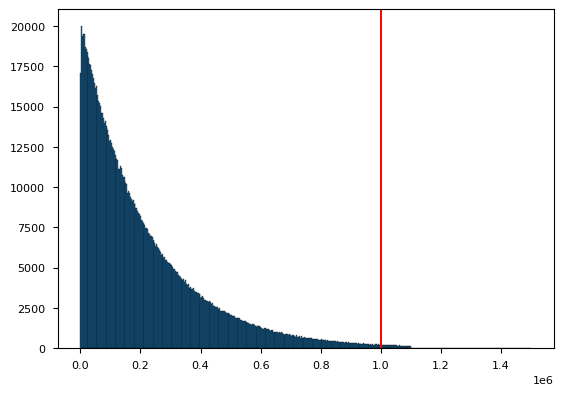

In [ ]:
#plt.scatter(np.arange(features_IBD["delta_time"][ features_IBD['Label'] ==1].shape[0]), features_IBD["delta_time"][ features_IBD['Label'] ==1], s=1)
# plt.scatter(np.arange(features_BKG["delta_time"].shape[0]), features_BKG["delta_time"], s=1)
plt.hist(features_IBD["delta_time"][features_IBD['Label'] == 1], np.linspace(0, 1.5e6, 500))
plt.axvline(1e6, c = 'red')

Delta radius

Ne perdiamo:  17208


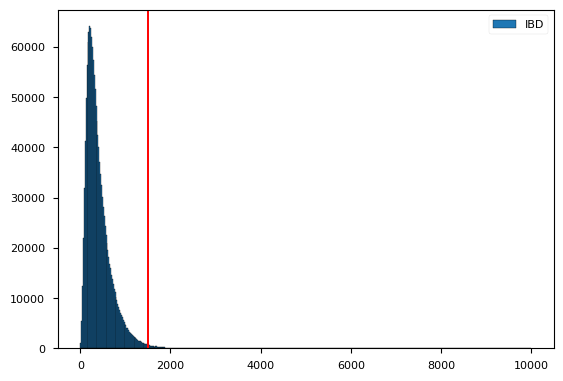

In [ ]:
# plt.scatter(np.arange(features_IBD["delta_radius"][features_IBD['Label'] == 1].shape[0]), features_IBD["delta_radius"][ features_IBD['Label'] == 1], s=1)
# plt.scatter(np.arange(features_BKG["delta_radius"].shape[0]), features_BKG["delta_radius"], s=1)
plt.hist(features_IBD["delta_radius"][features_IBD['Label'] == 1], np.linspace(0, 1e4, 500))
# plt.hist(features_IBD["delta_radius"][features_IBD['Label'] == 0], np.linspace(0, 1e4, 10))
plt.legend(["IBD", "BKG"])
count = np.logical_and(True, features_IBD["delta_radius"]>1500)
print("Ne perdiamo: ", count.sum())
plt.axvline(1500, c = 'red')

# Cutting algorithm for BOTH IBD and BKG

In [ ]:
@njit(parallel = True) 
#delta time in nanoseconds
#delta radius in mm
def selection(dt,dr,E_pro,E_del, delta_time = 1e6, delta_radius = 1500, min_energy_prompt = 0.7,max_energy_prompt = 12, min_energy_delay = 1.9, max_energy_delay = 2.5, min_energy_delay_carb = 4.4, max_energy_delay_carb = 5.5):
    prompt_columns = np.zeros(dt.shape)
    delay_columns = np.zeros(dt.shape)
    delay_columns_carb = np.zeros(dt.shape)
    for i in prange(dt.shape[0]):
        if dt[i] < delta_time: 
            if dr[i] < delta_radius: 
                if E_pro[i]>= min_energy_prompt and E_pro[i]<= max_energy_prompt:
                    if E_del[i]>= min_energy_delay and E_del[i]<= max_energy_delay:
                        prompt_columns[i] = 1
                        delay_columns[i] = 1
                    if E_del[i]>= min_energy_delay_carb and E_del[i]<= max_energy_delay_carb:
                        prompt_columns[i] = 1
                        delay_columns_carb[i] = 1
    return prompt_columns,delay_columns,delay_columns_carb

### IBD selection, earching for true IBD events

In [ ]:
prompt_columns_IBD, delay_columns_IBD, delay_columns_carb_IBD = selection(features_IBD["delta_time"],
                                                                           features_IBD["delta_radius"],
                                                                           features_IBD["E_pro"],
                                                                           features_IBD["E_del"])

In [ ]:
print("Venongono selezionati come IBD ", prompt_columns_IBD.sum(),"Su un tot di", prompt_columns_IBD.shape[0])

print((prompt_columns_IBD.sum() * 100)/prompt_columns_IBD.shape[0])

TP = np.logical_and(features_IBD['Label'] == 1, prompt_columns_IBD == 1)
TN = np.logical_and(features_IBD['Label'] == 0, prompt_columns_IBD == 0)
FN = np.logical_and(features_IBD["Label"] == 1, prompt_columns_IBD == 0)
FP = np.logical_and(features_IBD["Label"] == 0, prompt_columns_IBD == 1) 

print("Efficiency: ", (TP.sum()/(TP.sum()+FN.sum())) * 100)
#Efficiency sono il numero di eventi IBD veri selezionati diviso il numero totale di IBD.
print("Purity: ", (TP.sum()/(TP.sum()+FP.sum())) * 100)	

Venongono selezionati come IBD  1435115.0 Su un tot di 1468385
97.73424544652799


ValueError: operands could not be broadcast together with shapes (1475009,) (1468385,) 

### BKG selection, searching for fake IBD eventi in BKG dataset

In [ ]:
prompt_columns_BKG, delay_columns_BKG, delay_columns_carb_BKG = selection(features_BKG["delta_time"],
                                                                           features_BKG["delta_radius"],
                                                                           features_BKG["E_pro"],
                                                                           features_BKG["E_del"])

In [ ]:
print(prompt_columns_BKG.sum(), prompt_columns_BKG.shape[0])
print(delay_columns_carb_BKG.sum(),delay_columns_carb_BKG.shape[0])
print(delay_columns_BKG.sum(),delay_columns_BKG.shape[0])

# DOMANDA 1: Il bkg dataset non ha SimID, quindi non posso fare la selezione dei veri bkg?
# TP = np.logical_and(features_BKG['Label'] == 1, prompt_columns_BKG == 1)
# TN = np.logical_and(features_BKG['Label'] == 0, prompt_columns_BKG == 0)
# FN = np.logical_and(features_BKG["Label"] == 1, prompt_columns_BKG == 0)
# FP = np.logical_and(features_BKG["Label"] == 0, prompt_columns_BKG == 1) 

# print("Efficiency: ", (TP.sum()/(TP.sum()+FN.sum())) * 100)
# print("Purity: ", (TP.sum()/(TP.sum()+FP.sum())) * 100)	

15.0 563532
0.0 563532
15.0 563532


### Plots after the cuts

(array([0.        , 0.01666081, 0.02221441, 0.01666081, 0.02499122,
        0.01110721, 0.02221441, 0.03609842, 0.01666081, 0.01666081,
        0.01943761, 0.02221441, 0.06108964, 0.04165203, 0.06108964,
        0.07775045, 0.16938491, 0.21381374, 0.36931464, 0.63311081,
        0.82193333, 1.28843604, 1.72439392, 2.41026397, 2.91286509,
        3.51265428, 4.06246104, 4.06523784, 3.97638018, 4.09022906,
        3.6959232 , 3.20165248, 2.50189843, 1.8410196 , 1.15237275,
        0.69420045, 0.39985946, 0.18882252, 0.08885766, 0.03609842,
        0.01666081, 0.01110721, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        ]),
 array([4.4       , 4.42244898, 4.44489796, 4.46734694, 4.48979592,
        4.5122449 , 4.53469388, 4.55714286, 4.57959184, 4.60204082,
        4.6244898 , 4.64693878, 4.66938776, 4.69183673, 4.71428571,
        4.73673469, 4.75918367, 4.78163265, 4.80408163, 4.82653061,
        4.84897959, 4.87142857, 4.89387755, 4.91632653, 4.

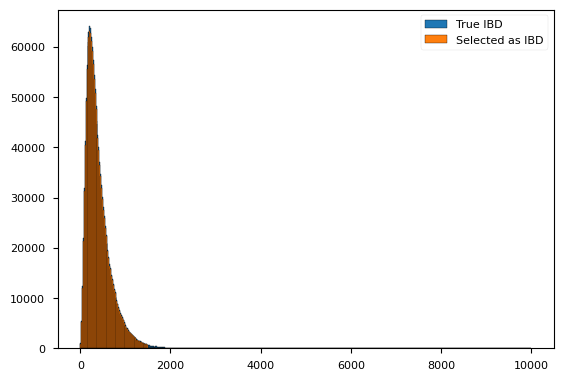

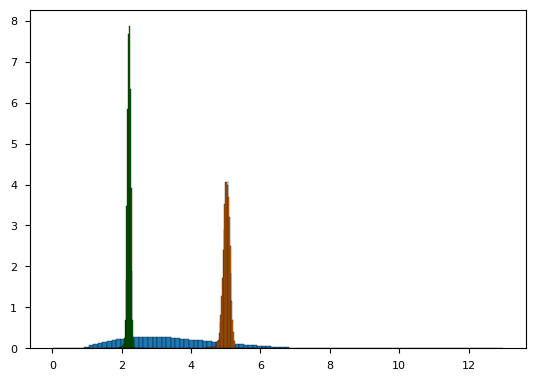

In [ ]:
fig2 = plt.figure()
plt.hist(features_IBD["delta_radius"][features_IBD['Label'] == 1], np.linspace(0, 1e4, 500))
plt.hist(features_IBD["delta_radius"][prompt_columns_IBD == 1], np.linspace(0, 1e4, 500))
plt.legend(["True IBD","Selected as IBD"])

fig3 = plt.figure()
plt.hist(features_IBD["E_pro"][prompt_columns_IBD == 1], np.linspace(0,13,100), density = True)
plt.hist(features_IBD["E_del"][delay_columns_IBD == 1], np.linspace(1.5,2.7,50), color= "green", density = True)
plt.hist(features_IBD["E_del"][delay_columns_carb_IBD == 1], np.linspace(4.4,5.5,50), density=True)

# Merging the IBD and BKG tables, but the tables before the cuts 

In [ ]:
def combine_dict(d1, d2):
    combined = {}
    for k in set(d1.keys()) | set(d2.keys()):
        if k in d1 and k in d2 and isinstance(d1[k], np.ndarray) and isinstance(d2[k], np.ndarray):
            combined[k] = np.concatenate([d1[k], d2[k]])
        elif k in d1:
            combined[k] = d1[k]
        else:
            combined[k] = d2[k]
    source = np.concatenate([np.full_like(d1.get(k, []), 1), np.full_like(d2.get(k, []), 0)])
    return {**combined, 'Source': source}
    

In [ ]:
all_feature = combine_dict(features_IBD,features_BKG)
print(all_feature)

{'E_del': array([2.25358   , 2.25309   , 2.18264   , ..., 0.14922771, 0.55319756,
       0.21764158]), 'E_pro': array([5.26223   , 1.16043   , 4.45989   , ..., 0.65679288, 0.1671035 ,
       0.60863018]), 'R_delayed': array([15381.68681502,  7549.91058534, 13683.06215751, ...,
       14189.24414062, 11007.74316406,  9359.60644531]), 'Label': array([1., 1., 1., ..., 0., 0., 0.]), 'delta_radius': array([  448.27860591,   321.95137047,   393.87693878, ...,
        6358.35253906, 18372.30078125, 13620.16503906]), 'delta_time': array([528976., 243136.,  16304., ..., 732471., 733249., 249284.]), 'R_prompt': array([15679.26747646,  7756.76478105, 13333.76935441, ...,
       17399.        , 11148.52832031, 17399.        ]), 'Source': array([1., 1., 1., ..., 0., 0., 0.])}


### Shuffle in random order

In [ ]:
# ottieni il numero di righe in ogni array
n_rows = all_feature['E_del'].shape[0]

# crea un nuovo ordine casuale degli indici delle righe
new_order = np.random.permutation(n_rows)

# estrai le righe nei nuovi indici
for key in all_feature:
    all_feature[key] = all_feature[key][new_order]


In [ ]:

print(all_feature)
print(all_feature['Label'].sum())

{'E_del': array([2.17341, 2.18525, 2.17214, ..., 2.10483, 2.15062, 2.28423]), 'E_pro': array([2.7247 , 4.50879, 2.27572, ..., 3.3086 , 2.75199, 4.41548]), 'R_delayed': array([10976.58836344, 14694.3567153 , 17400.00944839, ...,
       15057.72098322,  9344.71932915, 12152.63311745]), 'Label': array([1., 1., 1., ..., 1., 1., 1.]), 'delta_radius': array([195.70153321, 537.16716319, 137.56463717, ..., 224.55014518,
       402.04892911, 437.75964478]), 'delta_time': array([180352., 108240.,  21120., ...,  70400.,  10320.,  66720.]), 'R_prompt': array([11166.29610924, 14342.52881898, 17400.03660645, ...,
       14856.24644323,  9181.06275762, 11865.75555546]), 'Source': array([1., 1., 1., ..., 1., 1., 1.])}
1468385.0


Now some statistics about the data

In [ ]:
import pandas as pd
dataframe = pd.DataFrame({k:list(v) for k,v in all_feature.items()})
dataframe.describe()

,E_del,E_pro,R_delayed,Label,delta_radius,delta_time,R_prompt,Source
count,2.038541e+06,2.038541e+06,2.038541e+06,2.038541e+06,2.038541e+06,2.038541e+06,2.038541e+06,2.038541e+06
mean,1.844606e+00,2.722144e+00,1.378400e+04,7.203117e-01,6.111144e+03,3.060613e+05,1.379535e+04,7.235611e-01
std,1.349668e+00,2.002421e+00,3.500191e+03,4.488461e-01,9.966118e+03,2.826817e+05,3.489363e+03,4.472365e-01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.410000e+02,5.884042e-09,0.000000e+00
25%,1.644543e+00,1.388021e+00,1.166267e+04,0.000000e+00,2.526390e+02,8.324500e+04,1.167403e+04,0.000000e+00
50%,2.189700e+00,2.641230e+00,1.467379e+04,1.000000e+00,4.694779e+02,2.091680e+05,1.468621e+04,1.000000e+00
75%,2.234860e+00,3.896370e+00,1.689186e+04,1.000000e+00,1.076251e+04,4.538080e+05,1.689937e+04,1.000000e+00
max,3.913881e+02,3.913881e+02,1.740007e+04,1.000000e+00,3.479791e+04,1.099998e+06,1.740007e+04,1.000000e+00


In [ ]:
# import seaborn as sns


# g = sns.PairGrid(dataframe, hue="Label", hue_kws={"marker": ["o", "s"]})


# g.map_diag(sns.histplot)
# g.map_offdiag(sns.scatterplot)
# g.add_legend()



# Saving data

In [ ]:
print(all_feature.keys())

dict_keys(['E_del', 'E_pro', 'R_delayed', 'Label', 'delta_radius', 'delta_time', 'R_prompt', 'Source'])


I've tried using root but it did not worked 

In [ ]:

# import ROOT

# root_file = ROOT.TFile("Data/all_feature.root", "recreate")

# tree = ROOT.TTree("all_feature", "Tree with all features")

# # create a ROOT TBranch for each array
# branches = {}
# for key in all_feature.keys():
#     branches[key] = tree.Branch(key, all_feature[key], f"{key}[{len(all_feature[key])}]/F")

# # fill the tree with the array data
# for i in range(len(all_feature['delta_time'])):
#     for key in all_feature.keys():
#         all_feature[key][i] = (i+1)*(key+1)  # set each element to a different value
#         branches[key].Fill()   # fill the branch for this key only


# # write the tree to the ROOT file
# root_file.Write()
# root_file.Close()

In [ ]:
print(all_feature)

{'E_del': array([2.17341, 2.18525, 2.17214, ..., 2.10483, 2.15062, 2.28423]), 'E_pro': array([2.7247 , 4.50879, 2.27572, ..., 3.3086 , 2.75199, 4.41548]), 'R_delayed': array([10976.58836344, 14694.3567153 , 17400.00944839, ...,
       15057.72098322,  9344.71932915, 12152.63311745]), 'Label': array([1., 1., 1., ..., 1., 1., 1.]), 'delta_radius': array([195.70153321, 537.16716319, 137.56463717, ..., 224.55014518,
       402.04892911, 437.75964478]), 'delta_time': array([180352., 108240.,  21120., ...,  70400.,  10320.,  66720.]), 'R_prompt': array([11166.29610924, 14342.52881898, 17400.03660645, ...,
       14856.24644323,  9181.06275762, 11865.75555546]), 'Source': array([1., 1., 1., ..., 1., 1., 1.])}


In [ ]:
np.savetxt("../../../../mnt/fcufino/all_features.csv", np.column_stack(list(all_feature.values())), delimiter=",", header=",".join(list(all_feature.keys())), comments="")

NameError: name 'np' is not defined

# Cut Algorithm 

In [ ]:
prompt_columns, delay_columns, delay_columns_carb = selection(all_feature["delta_time"],
                                                              all_feature["delta_radius"],
                                                              all_feature["E_pro"],
                                                              all_feature["E_del"])

In [ ]:
TP = np.logical_and(all_feature['Label'] == 1, prompt_columns == 1)
TN = np.logical_and(all_feature['Label'] == 0, prompt_columns == 0)
FN = np.logical_and(all_feature["Label"] == 1, prompt_columns == 0)
FP = np.logical_and(all_feature["Label"] == 0, prompt_columns == 1) 

print("Efficiency: ", (TP.sum()/(TP.sum()+FN.sum())) * 100)
print("Purity: ", (TP.sum()/(TP.sum()+FP.sum())) * 100)	

Efficiency:  97.73424544652799
Purity:  99.99818833132076
